# Journey through some Exploration Algorithms

### Introduction: 
    Exploration is cool

### Requirements:
- [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html)
- [Explauto](https://github.com/flowersteam/explauto)

Might need to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension'

To run this notebook:

    jupyter notebook main.ipynb

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

from numpy import pi, array, linspace, hstack
from matplotlib import animation
from IPython.display import HTML, display
from ipywidgets import interact_manual
from numpy.random import random


from environment import Arm, Ball, ArmBall
from explauto import SensorimotorModel
from explauto import InterestModel
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto.utils import rand_bounds
from explauto.environment.dynamic_environment import DynamicEnvironment
from modular_environment import HierarchicalEnvironment
from utils import compute_explo

grid_size = 20

## I. Exploring the movements of a robotic arm

Configuration of a dynamic environment with an arm and a ball to catch.

The 3 joints are controlled through DMPs with 3 basis functions (9 motor parameters in total).

The environments can be instantiated either with the following configuration, or directly with 'ArmBall()'.

In [2]:
arm_config = dict(
    m_mins=[-1.] * 3,
    m_maxs=[1.] * 3, 
    s_mins=[-1.] * 3,
    s_maxs=[1.] * 3, 
    lengths=[0.5, 0.3, 0.2], 
    angle_shift=0.5,
    rest_state=[0.] * 3)

ball_config = dict(
    m_mins=[-1.] * 2,
    m_maxs=[1.] * 2, 
    s_mins=[-1.] * 2,
    s_maxs=[1.] * 2,
    size=0.1,
    initial_position=[0.6, 0.6],
    color="b")

arm_ball_cfg = dict(
    m_mins=[-1.] * 3,
    m_maxs=[1.] * 3,
    s_mins=[-1.] * 2,
    s_maxs=[1.] * 2,
    top_env_cls=Ball, 
    lower_env_cls=Arm, 
    top_env_cfg=ball_config, 
    lower_env_cfg=arm_config, 
    fun_m_lower= lambda m:m,
    fun_s_lower=lambda m,s:s[0:2],
    fun_s_top=lambda m,s_lower,s:s)

dynamic_environment_config = dict(
    env_cfg=arm_ball_cfg,
    env_cls=HierarchicalEnvironment,
    m_mins=[-1.] * 3 * 3, 
    m_maxs=[1.] * 3 * 3, 
    s_mins=[-1] * 3 * 2,
    s_maxs=[1] * 3 * 2,
    n_bfs=3,
    move_steps=50, 
    n_dynamic_motor_dims=3,
    n_dynamic_sensori_dims=2, 
    max_params=1000)

environment1 = DynamicEnvironment(**dynamic_environment_config)

#environment = ArmBall()

Control the arm through the 9 following sliders (and hit "Run" button).

Try to catch the ball !

<function __main__.movement>

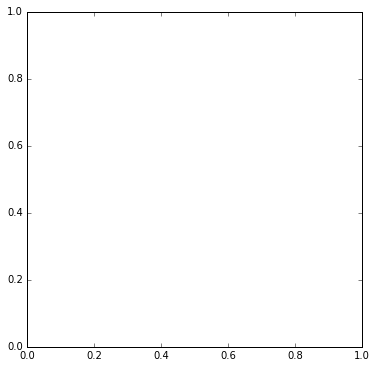

In [3]:
# Had to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension'
fig, ax = plt.subplots()

def movement(m1=0., m2=0., m3=0., m4=0., m5=0., m6=0., m7=0., m8=0., m9=0.):
    environment1.update(array([m1, m2, m3, m4, m5, m6, m7, m8, m9]))
    display(HTML(environment1.plot(fig, ax)))
    
interact_manual(movement, m1=(-1., 1., 0.01), m2=(-1., 1., 0.01), m3=(-1., 1., 0.01), 
                          m4=(-1., 1., 0.01), m5=(-1., 1., 0.01), m6=(-1., 1., 0.01), 
                          m7=(-1., 1., 0.01), m8=(-1., 1., 0.01), m9=(-1., 1., 0.01))


## II. Random Motor Babbling

Let's use a higher dimensional arm.

In [4]:
arm_config = dict(
    m_mins=[-1.] * 7,
    m_maxs=[1.] * 7, 
    s_mins=[-1.] * 3,
    s_maxs=[1.] * 3, 
    lengths=[0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05], 
    angle_shift=0.5,
    rest_state=[0.] * 7)

ball_config = dict(
    m_mins=[-1.] * 2,
    m_maxs=[1.] * 2, 
    s_mins=[-1.] * 2,
    s_maxs=[1.] * 2,
    size=0.1,
    initial_position=[0.6, 0.6],
    color="b")

arm_ball_cfg = dict(
    m_mins=[-1.] * 7,
    m_maxs=[1.] * 7,
    s_mins=[-1.] * 2,
    s_maxs=[1.] * 2,
    top_env_cls=Ball, 
    lower_env_cls=Arm, 
    top_env_cfg=ball_config, 
    lower_env_cfg=arm_config, 
    fun_m_lower= lambda m:m,
    fun_s_lower=lambda m,s:s[0:2],
    fun_s_top=lambda m,s_lower,s:s)
    #fun_s_top=lambda m,s_lower,s:s_lower[0:2] + s)

dynamic_environment_config = dict(
    env_cfg=arm_ball_cfg,
    env_cls=HierarchicalEnvironment,
    m_mins=[-1.] * 3 * 7, 
    m_maxs=[1.] * 3 * 7, 
    s_mins=[-1] * 3 * 2,
    s_maxs=[1] * 3 * 2,
    n_bfs=3,
    move_steps=50, 
    n_dynamic_motor_dims=7,
    n_dynamic_sensori_dims=2, 
    max_params=1000)

environment2 = DynamicEnvironment(**dynamic_environment_config)


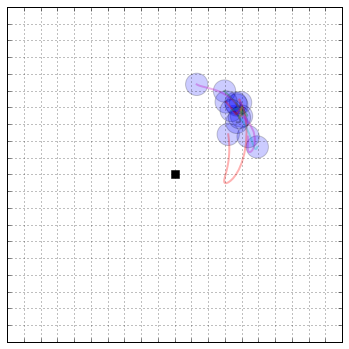

In [5]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.plot(0., 0., 'sk', ms=8)
explored_s_mb = []

for _ in range(1000):
    m = environment2.random_motors()[0]
    s = environment2.update(m)
    if abs(s[-1] - s[-3]) > 0.01:
        explored_s_mb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.3)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), ball_config["size"], fc=ball_config["color"], alpha=0.2))
        
plt.xticks(linspace(-1.5, 1.5, grid_size + 1))
plt.yticks(linspace(-1.5, 1.5, grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

### Exploration measure
We compute the number of cells in the above grid where the ball has been placed at the end of the different movements.

In [6]:
print "Number of ball catch:", len(explored_s_mb)
print "Number of reached cells:", int(compute_explo(array(explored_s_mb)[:,[2,5]], array([-1.5, -1.5]), array([1.5, 1.5]), gs=grid_size))

Number of ball catch: 13
Number of reached cells: 7


## III. Random Goal Babbling


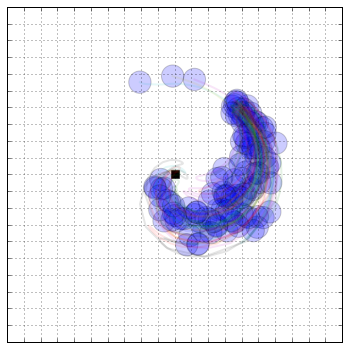

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.plot(0., 0., 'sk', ms=8)
explored_s_gb = []

sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
#model = NonParametric(environment.conf, **{'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio':0.1})

# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(1000):
    if random() < 0.3:
        m = environment2.random_motors()[0]
    else:
        s_goal = rand_bounds(environment2.conf.s_bounds)[0]
        m = sm_model.inverse_prediction(s_goal)
    s = environment2.update(m)
    sm_model.update(m, s)
    if abs(s[-1] - s[-3]) > 0.01:
        explored_s_gb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), ball_config["size"], fc=ball_config["color"], alpha=0.2))
        
plt.xticks(linspace(-1.5, 1.5, grid_size + 1))
plt.yticks(linspace(-1.5, 1.5, grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

In [8]:
print "Number of ball catch:", len(explored_s_gb)
print "Number of reached cells:", int(compute_explo(array(explored_s_gb)[:,[2,5]], array([-1.5, -1.5]), array([1.5, 1.5]), gs=grid_size))

Number of ball catch: 120
Number of reached cells: 41


## IV. Active Goal Babbling

Active learning can be helpful.

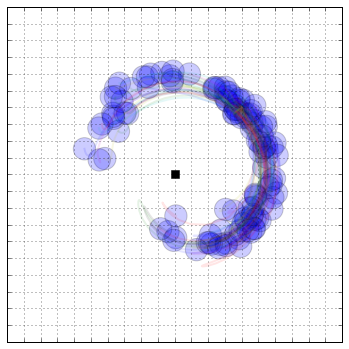

In [9]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb = []

sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
im_model = InterestModel.from_configuration(environment2.conf, environment2.conf.s_dims, 'tree')


# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(1000):
    if random() < 0.3:
        m = environment2.random_motors()[0]
        s = environment2.update(m)
        sm_model.update(m, s)
    else:
        # sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # infer a motor command to reach that goal using the sensorimotor model:
        m = sm_model.inverse_prediction(s_goal)
        # execute this command and observe the corresponding sensory effect:
        s = environment2.update(m)
        # update the sensorimotor model:
        sm_model.update(m, s)
        # update the interest model:
        im_model.update(hstack((m, s)), hstack((m, s_goal)))
    # plot the observed sensory effect:
    if abs(s[-1] - s[-3]) > 0.01:
        explored_s_agb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), ball_config["size"], fc=ball_config["color"], alpha=0.2))
        
plt.xticks(linspace(-1.5, 1.5, grid_size + 1))
plt.yticks(linspace(-1.5, 1.5, grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

In [10]:
print "Number of ball catch:", len(explored_s_agb)
print "Number of reached cells:", int(compute_explo(array(explored_s_agb)[:,[2,5]], array([-1.5, -1.5]), array([1.5, 1.5]), gs=grid_size))

Number of ball catch: 118
Number of reached cells: 42


## V. More complex environment

Test AGB

=> Need to change the representation

## VI. Model Babbling